In [5]:
import numpy as np
import matplotlib.pyplot as plt

def mind(x, y, z, dincl, ddecl, x0, y0, z0, aincl, adecl):
    """
    Calculate the magnetic field of a magnetic dipole at a given location
    
    Parameters
    ----------
    x : float
        x location of the observation point
    y : float
        y location of the observation point
    z : float
        z location of the observation point
    dincl : float
        inclination of the dipole moment (degrees)
    ddecl : float
        declination of the dipole moment (degrees)
    x0 : float
        x location of the dipole
    y0 : float
        y location of the dipole
    z0 : float
        z location of the dipole
    aincl : float
        inclination of the inducing field (degrees)
    adecl : float
        declination of the inducing field (degrees)
    """

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    z = np.array(z, dtype=float)
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    z0 = np.array(z0, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    aincl = np.array(aincl, dtype=float)
    adecl = np.array(adecl, dtype=float)

    di = np.pi * dincl / 180.0
    dd = np.pi * ddecl / 180.0

    cx = np.cos(di) * np.cos(dd)
    cy = np.cos(di) * np.sin(dd)
    cz = np.sin(di)

    ai = np.pi * aincl / 180.0
    ad = np.pi * adecl / 180.0

    ax = np.cos(ai) * np.cos(ad)
    ay = np.cos(ai) * np.sin(ad)
    az = np.sin(ai)

    # begin the calculation
    a = x - x0
    b = y - y0
    h = z - z0

    rt = np.sqrt(a ** 2.0 + b ** 2.0 + h ** 2.0) ** 5.0

    txy = 3.0 * a * b / rt
    txz = 3.0 * a * h / rt
    tyz = 3.0 * b * h / rt

    txx = (2.0 * a ** 2.0 - b ** 2.0 - h ** 2.0) / rt
    tyy = (2.0 * b ** 2.0 - a ** 2.0 - h ** 2.0) / rt
    tzz = -(txx + tyy)

    bx = txx * cx + txy * cy + txz * cz
    by = txy * cx + tyy * cy + tyz * cz
    bz = txz * cx + tyz * cy + tzz * cz

    return bx * ax + by * ay + bz * az

def rotate_coordinates(coords, incl, decl):
    # convert to radians
    incl = np.deg2rad(incl)
    decl = np.deg2rad(decl)

    # Rotation matrix for inclination (around y-axis)
    R_incl = np.array([
        [np.cos(incl), 0, np.sin(incl)],
        [0, 1, 0],
        [-np.sin(incl), 0, np.cos(incl)]
    ])
    
    # Rotation matrix for declination (around z-axis)
    R_decl = np.array([
        [np.cos(decl), -np.sin(decl), 0],
        [np.sin(decl), np.cos(decl), 0],
        [0, 0, 1]
    ])
    
    # Apply rotation
    rotated_coords = R_decl @ (R_incl @ coords)
    
    return rotated_coords

def fem_pipe(
        sigma, mu, xc, yc, zc, dincl, ddecl, dipole_dist, sensor_ht, f, xmin, xmax, dx, N_loops, length, rad, 
):
    
    sigma = np.array(sigma, dtype=float)
    mu = np.array(mu, dtype=float)
    xc = np.array(xc, dtype=float)
    yc = np.array(yc, dtype=float)
    zc = np.array(zc, dtype=float)
    dincl = np.array(dincl, dtype=float)
    ddecl = np.array(ddecl, dtype=float)
    dipole_dist = np.array(dipole_dist, dtype=float)
    sensor_ht = np.array(sensor_ht, dtype=float)
    f = np.array(f, dtype=float)
    dx = np.array(dx, dtype=float)
    N_loops = np.array(N_loops, dtype=int)
    length = np.array(length, dtype=float)
    rad = np.array(rad, dtype=float)

    R = N_loops * np.pi * rad * np.sqrt(4*np.pi*mu/sigma) / length
    L = 4*np.pi * 10**(-7) * N_loops**2 / (np.pi * length * rad**2)

    ymin = xmin
    ymax = xmax
    dy = dx

    # generate the grid
    xp = np.arange(xmin, xmax, dx)
    yp = np.arange(ymin, ymax, dy)
    [y, x] = np.meshgrid(yp, xp)
    z = 0.0 * x - sensor_ht

    # frequency characteristics
    alpha = 2.0 * np.pi * f * L / R
    f_factor = (alpha ** 2.0 + 1j * alpha) / (1 + alpha ** 2.0)

    # compute distances
    y_tx = y - dipole_dist / 2.0
    y_rx = y + dipole_dist / 2.0

    # define the cylinder
    x_centers = np.linspace(-length / 2, length / 2, N_loops) + xc
    loop_centers = np.c_[x_centers, np.zeros(N_loops) + yc, np.zeros(N_loops) + zc]
    loop_centers = rotate_coordinates(loop_centers.T, dincl, ddecl).T
    
    # compute the response
    MTR = mind(0.0, -dipole_dist / 2.0, 0.0, 90.0, 0.0, 0.0, dipole_dist / 2.0, 0.0, 90.0, 0.0)

    mut_ind = 0
    for i in range(N_loops):
        xci, yci, zci = loop_centers[i, 0], loop_centers[i, 1], loop_centers[i, 2]
        MTk = mind(x, y_tx, z, 90.0, 0.0, xci, yci, zci, dincl, ddecl)
        MkR = mind(xci, yci, zci, dincl, ddecl, x, y_rx, z, 90.0, 0.0)
        mut_ind += MTk * MkR

    c_response = -mut_ind * f_factor / (MTR * L)

    return c_response

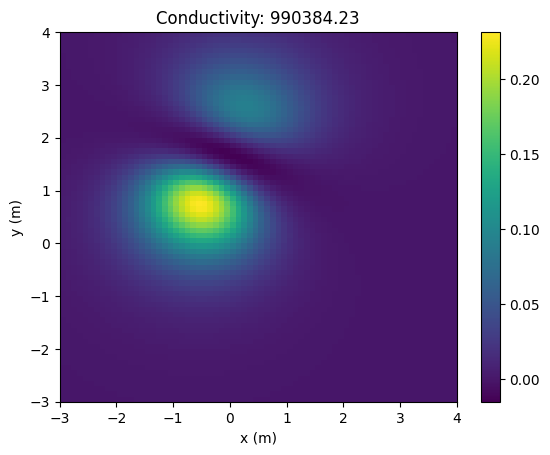

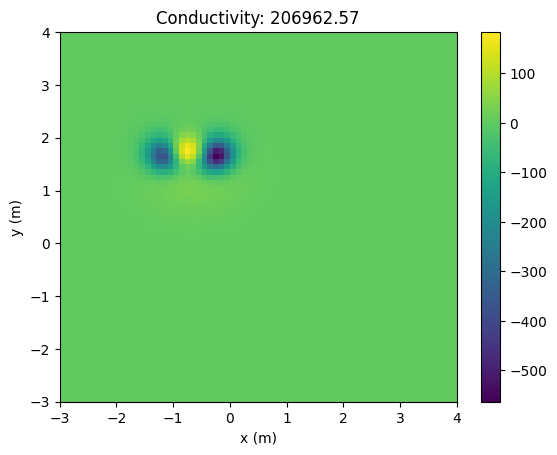

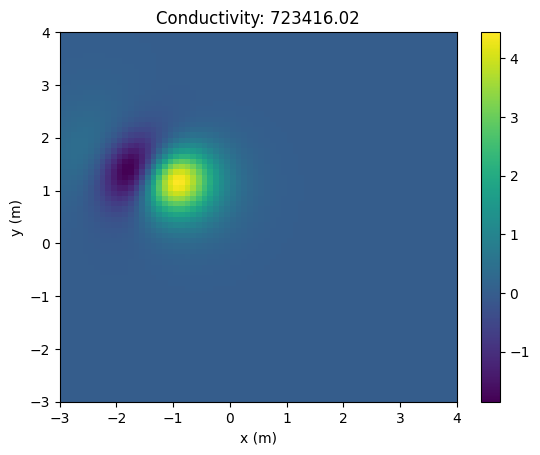

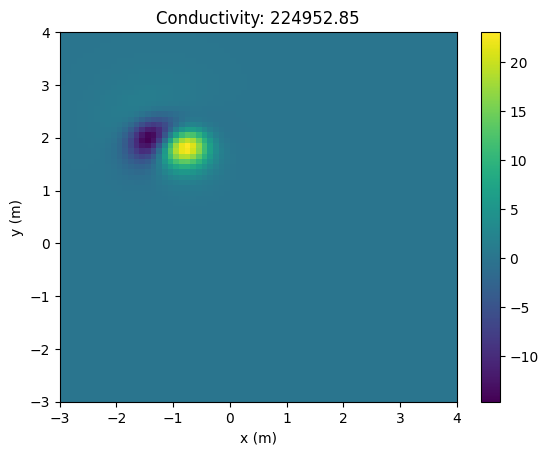

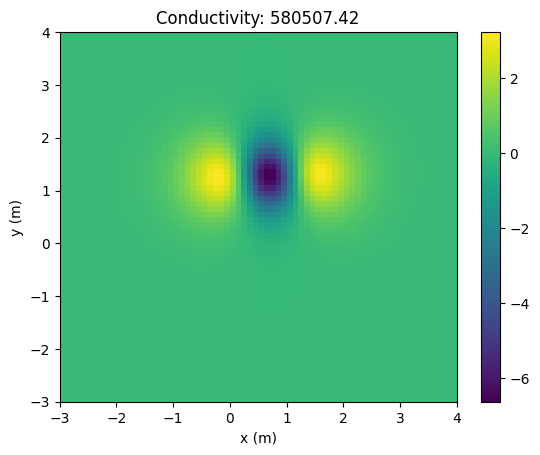

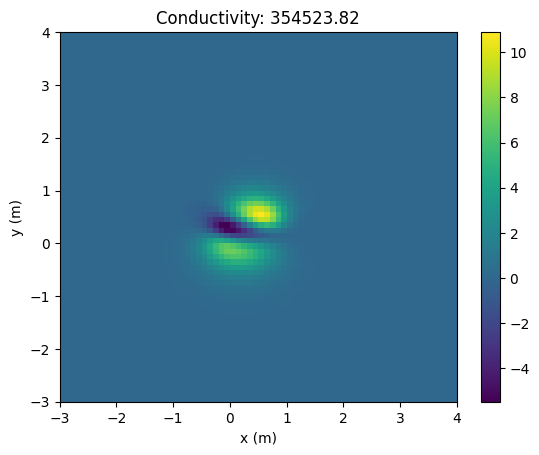

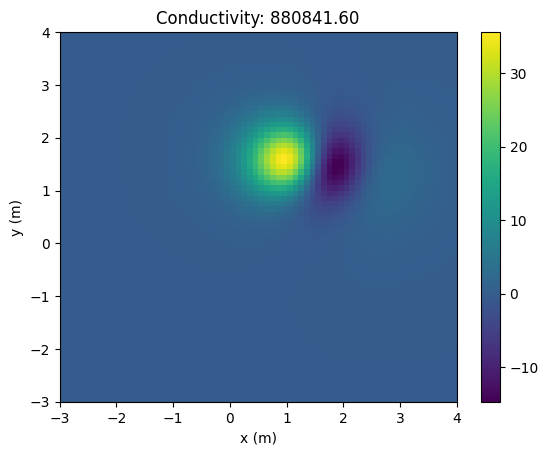

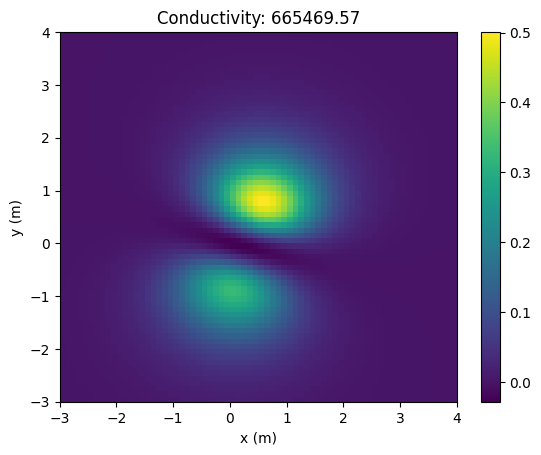

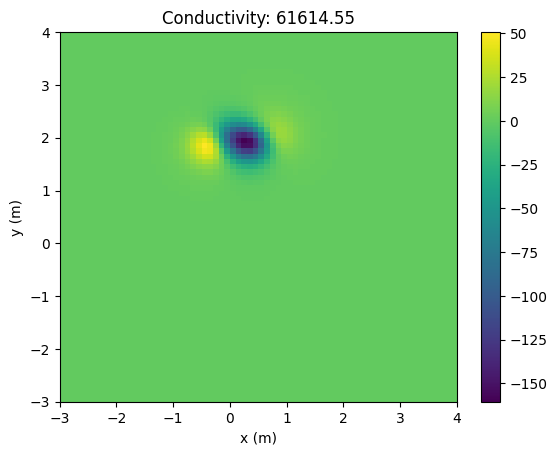

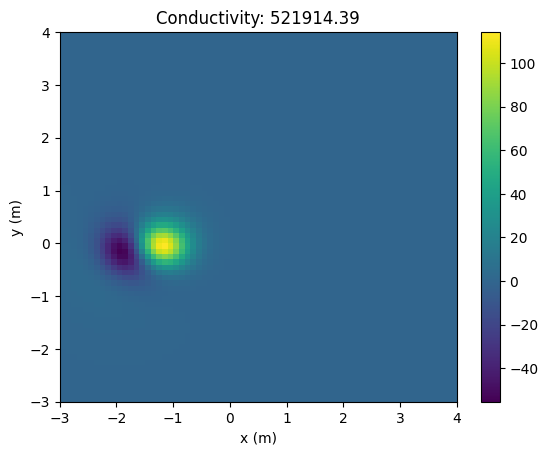

In [13]:
n_sims = 10

conductivity = np.random.uniform(1e4, 1e6, n_sims)
permeability = 4*np.pi*1e-7 # free space permeability
xc = np.random.uniform(0, 1, n_sims)
yc = np.random.uniform(0, 1, n_sims)
zc = np.random.uniform(0.5, 2, n_sims)
dincl = np.random.uniform(0, 90, n_sims)
ddecl = np.random.uniform(0, 360, n_sims)
dipole_dist = 1 # 1 m spacing
sensor_ht = 0.05 # fixed height of the sensor. Can change accordingly
x_min = -3
x_max = 4
dx = 0.1
n_loops = 50
length = np.random.uniform(0.05, 0.2, n_sims)
rad = np.random.uniform(1/6, 1, n_sims) * length

freqs = np.logspace(3, 5, 8)

for i in range(n_sims):
    response = fem_pipe(
        conductivity[i], permeability, xc[i], yc[i], zc[i], dincl[i], ddecl[i], dipole_dist, sensor_ht, freqs[-1], x_min, x_max, dx, n_loops, length[i], rad[i]
    )
    
    plt.figure()
    plt.imshow(np.real(response), extent=[x_min, x_max, x_min, x_max], aspect='auto')
    plt.colorbar()
    plt.title('Conductivity: {:.2f}'.format(conductivity[i]))
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')